In [19]:
# Inspired by https://www.kaggle.com/ashwani07/mnist-classification-using-random-forest

In [1]:
import requests
from pathlib import Path

In [2]:
import sys
print(sys.version)

3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:20:19) [MSC v.1925 32 bit (Intel)]


## Download Dataset

In [3]:
mnist_file = 'mnist.csv'
mnist_file_path = Path(mnist_file)
if not mnist_file_path.is_file():
    # file exists
    print('Dataset does not exist. Downloading...')
    csv_url = 'https://raw.githubusercontent.com/MSc-in-Data-Science/class_material/master/semester_1/Machine_Learning/datasets/digit_recognizer_dataset.csv'
    req = requests.get(csv_url)
    url_content = req.content
    csv_file = open('mnist.csv', 'wb')

    csv_file.write(url_content)
    csv_file.close()
    print('Dataset Downloaded')
else:
    print('Dataset exists')

Dataset exists


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [5]:
#Load other modules
import matplotlib.pyplot as plt  #Graphics
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.model_selection import cross_val_score
#To show graphs within the notebook
%matplotlib inline 

In [6]:
#load the datasets
train = pd.read_csv("mnist.csv")
# test = pd.read_csv("../input/test.csv")

In [7]:
#Printing the size of the dataframe
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))
# print ("Testing dataset has %i observations and %i variables" %(test.shape[0], test.shape[1]))

Training dataset has 42000 observations and 785 variables


In [8]:
#check few rows
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Seperate the target and independant variables
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]

In [10]:
def print_image(row, df):
    temp=df.iloc[row,:].values
    temp = temp.reshape(28,28).astype('uint8')
    plt.imshow(temp)

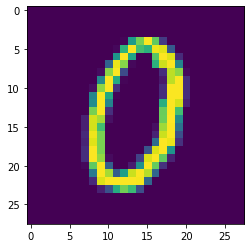

In [11]:
print_image(5, df_x)

In [12]:
#Check the frequency of each number
df_y.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

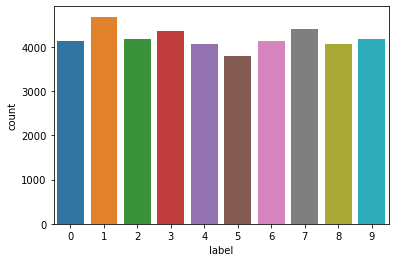

In [13]:
sns.countplot(df_y)

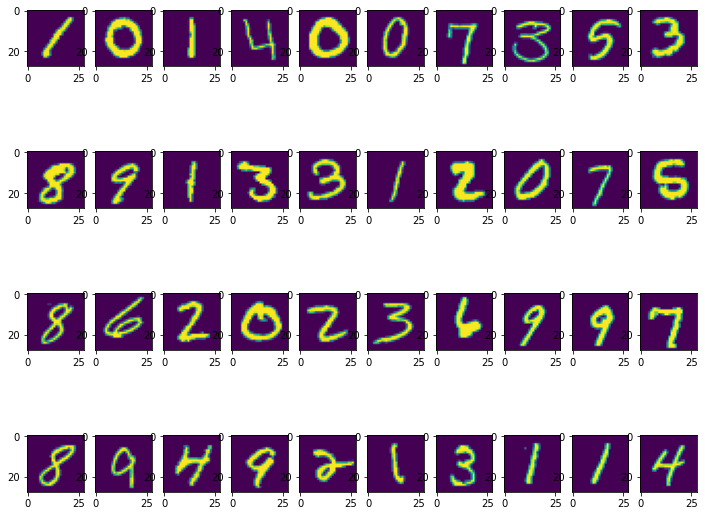

In [14]:
plt.figure(figsize=(12,10))
for i in range(40):
    plt.subplot(4, 10, i+1)
    print_image(i, df_x)

In [15]:
#Split the dataset
df_x = df_x.astype('int32')
df_y = df_y.astype('int32')

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)

(29400, 784)
(12600, 784)


In [16]:
#training random Forest
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1242
           1       0.99      0.98      0.98      1429
           2       0.96      0.97      0.96      1276
           3       0.96      0.94      0.95      1298
           4       0.97      0.97      0.97      1236
           5       0.96      0.96      0.96      1119
           6       0.97      0.98      0.97      1243
           7       0.97      0.95      0.96      1334
           8       0.95      0.95      0.95      1204
           9       0.94      0.94      0.94      1219

    accuracy                           0.96     12600
   macro avg       0.96      0.96      0.96     12600
weighted avg       0.96      0.96      0.96     12600

Confusion Report
[[1217    0    0    1    3    3    9    0    8    1]
 [   0 1402   10    2    2    2    7    1    3    0]
 [   6    0 1236    8    6    1    2    8    7    2]
 [   4    0   19 1223    0   14    4   12  

In [18]:
#Cross validation
rf=RandomForestClassifier(n_estimators=100)
rf.fit(df_x, df_y)
score = cross_val_score(rf, df_x, df_y)
print (np.mean(score))

MemoryError: Unable to allocate 126. MiB for an array with shape (42000, 784) and data type float32